In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')  # or the model name you fine-tuned from

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [3]:
#load the model
model = tf.saved_model.load("/kaggle/input/src-clss/sentiment_model_class")

In [21]:
#load the dataset
dft = pd.read_csv('/kaggle/input/birdyfinal/test.csv')

In [22]:
classes = [
    'Online and Social Media Related Crime',
    'Online Financial Fraud',
    'Any Other Cyber Crime',
    'Sexually Explicit Act',
    'Cyber Attack/ Dependent Crimes',
    'Hacking  Damage to computercomputer system etc',
    'Cryptocurrency Crime',
    'RapeGang Rape RGRSexually Abusive Content',
    'Sexually Obscene material',
    'Online Gambling  Betting',
    'Cyber Terrorism',
    'Online Cyber Trafficking',
    'Child Pornography CPChild Sexual Abuse Material CSAM',
    'Ransomware',
    'Report Unlawful Content'
]
label2id = {label: idx for idx, label in enumerate(classes)}
id2label = {idx: label for idx, label in enumerate(classes)}


In [23]:
# Prepare the data for prediction
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token['input_ids'], tf.int32),
        'attention_mask': tf.cast(token['attention_mask'], tf.int32)
    }

# Make predictions with the model
def make_prediction(model, processed_data):
    predict_fn = model.signatures["serving_default"]
    output = predict_fn(input_ids=processed_data['input_ids'], attention_mask=processed_data['attention_mask'])
    
    if 'output_layer' in output:
        probs = output['output_layer'].numpy()
    else:
        raise KeyError("Expected key 'output_layer' not found in output")
    
    return np.argmax(probs, axis=1)[0]  # Return the predicted class (single value)


In [24]:
dft = dft.dropna(subset=['crimeaditionalinfo'])
dft['sub_category'] = dft['sub_category'].fillna(dft['category'])
dft = dft.sample(frac=1.0, random_state=42)
dft['category'], dft['sub_category'] = dft['sub_category'], dft['category']
dft["labels"] = dft['sub_category'].map(lambda x: label2id.get(x.strip(), 1))  # Default to 1 if not found

Processing rows:   0%|          | 0/31222 [00:00<?, ?it/s]

Accuracy: 0.81
Precision: 0.7578333333333334
Recall: 0.81
F1 Score: 0.7644726681568786


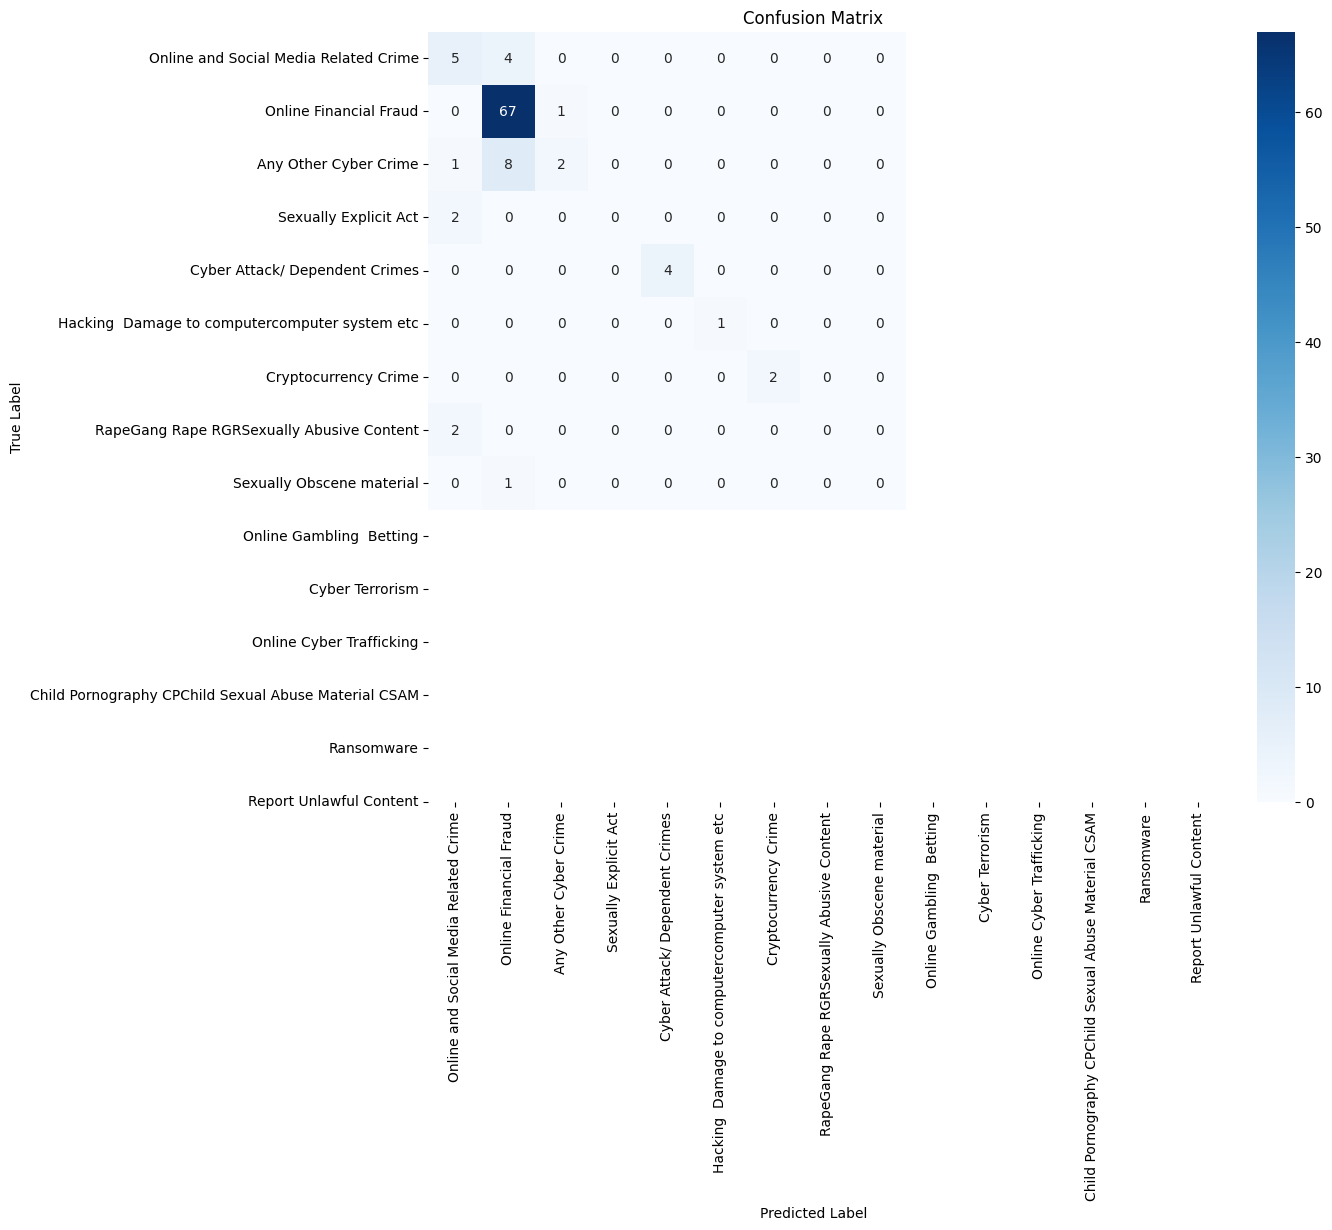

In [25]:
# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Loop over each row in the DataFrame with tqdm for progress tracking
for idx, row in tqdm(dft.iterrows(), total=len(dft), desc="Processing rows"):
    text = row['crimeaditionalinfo']
    actual_label = row['labels']
    processed_data = prepare_data(text, tokenizer)
    predicted_class = make_prediction(model, processed_data)
    
    # Store true and predicted labels
    y_true.append(actual_label)
    y_pred.append(predicted_class)  # Append single predicted class

    # if actual_label != predicted_class:
    #     print("Text:", text)
    #     print("Actual Label:", classes[actual_label])
    #     print("Predicted Label:", classes[predicted_class])
    #     print()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[id2label[i] for i in range(15)],
            yticklabels=[id2label[i] for i in range(15)],
            cbar=True, square=True)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [37]:
text = 'upi'
processed_data = prepare_data(text, tokenizer)
predicted_class = make_prediction(model, processed_data)
print("Text:", text)
print("Predicted Label:", classes[predicted_class])

Text: upi
Predicted Label: Online Financial Fraud
